# 1. 이미지 전처리

### CUDA

In [117]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("사용 가능한 GPU 개수:", torch.cuda.device_count())
print("GPU:", torch.cuda.get_device_name(device=device))
print("VRAM 사용량:", torch.cuda.memory_usage(device=device))
print("GPU 온도:", torch.cuda.temperature(device=device))

사용 가능한 GPU 개수: 1
GPU: NVIDIA GeForce RTX 4060 Ti
VRAM 사용량: 0
GPU 온도: 52


### 라이브러리 임포트

In [118]:
import os
import cv2
import random
import numpy as np
import skimage
import umap
import hdbscan
import pandas as pd
import torch
import sys

from glob import glob
from collections import Counter
from tqdm.auto import tqdm
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

In [119]:
BATCH_SIZE = 16
SEED = 42

In [120]:
# https://huggingface.co/geolocal/StreetCLIP
# StreetCLIP is a robust foundation model for open-domain image geolocalization and other geographic and climate-related tasks.

clip_model = CLIPModel.from_pretrained("geolocal/StreetCLIP")
clip_model.to('cuda')
clip_processor = CLIPProcessor.from_pretrained("geolocal/StreetCLIP")

In [121]:
image_paths = sorted(glob('./train_gt/*.png'))

In [122]:
image_features = []

'''for i in tqdm(range(0,len(image_paths), BATCH_SIZE)):
    image_paths_batch = image_paths[i:i+BATCH_SIZE]
    images = [Image.open(image_path) for image_path in image_paths_batch]
    pixel_values = clip_processor.image_processor(images=images, return_tensors='pt')['pixel_values'].to('cuda')
    with torch.no_grad():
        image_features_row = clip_model.get_image_features(pixel_values).cpu().numpy()
    image_features.append(image_features_row) '''

"for i in tqdm(range(0,len(image_paths), BATCH_SIZE)):\n    image_paths_batch = image_paths[i:i+BATCH_SIZE]\n    images = [Image.open(image_path) for image_path in image_paths_batch]\n    pixel_values = clip_processor.image_processor(images=images, return_tensors='pt')['pixel_values'].to('cuda')\n    with torch.no_grad():\n        image_features_row = clip_model.get_image_features(pixel_values).cpu().numpy()\n    image_features.append(image_features_row) "

In [123]:
#train_embeddings =/ np.vstack(image_features)

In [124]:
#train_embeddings = normalize(train_embeddings, norm="l2")

In [125]:
# np.save('./preproc/train_embeddings', train_embeddings)
train_embeddings = np.load('./train_embeddings.npy')

### UMAP을 통해 이미지 임베딩을 클러스터링하기

In [126]:
clusterable_embedding = umap.UMAP(
    n_neighbors=5,
    min_dist=0.0,
    n_components=2,
    random_state=SEED,
).fit_transform(train_embeddings)

/home/gooruem/anaconda3/envs/IMGRT/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/gooruem/anaconda3/envs/IMGRT/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/gooruem/anaconda3/envs/IMGRT/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


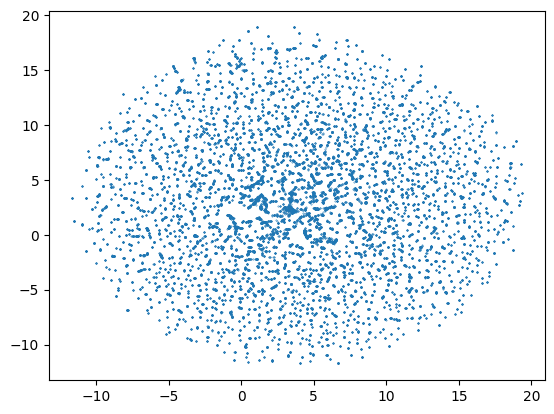

In [127]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1)

In [128]:
labels = hdbscan.HDBSCAN(
    min_cluster_size=5,
).fit_predict(clusterable_embedding)

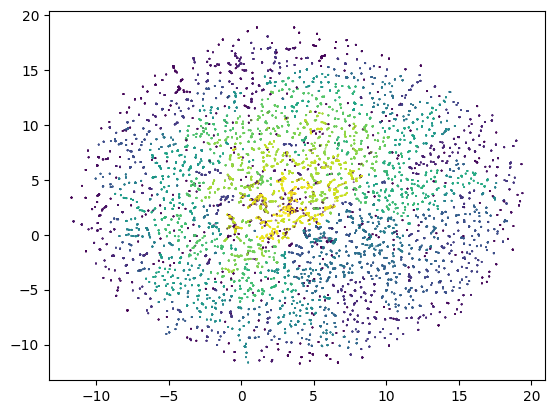

In [129]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=labels, s=0.1)

In [130]:
len(set(labels)), sum(labels==-1)

(2471, 1977)

In [131]:
counter = Counter([label for label in labels if label!=-1])

In [132]:
min(counter.values()), np.median(list(counter.values())), max(counter.values())

(5, 10.0, 64)

## 클러스터 별 이미지 확인 및 저장하기

label is 0


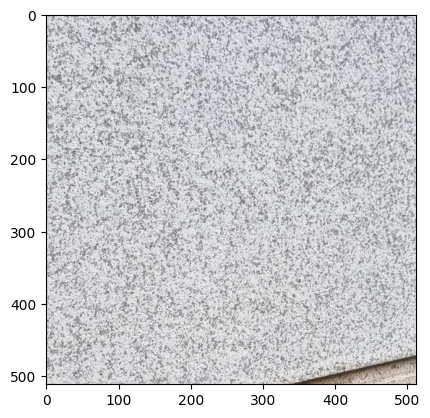

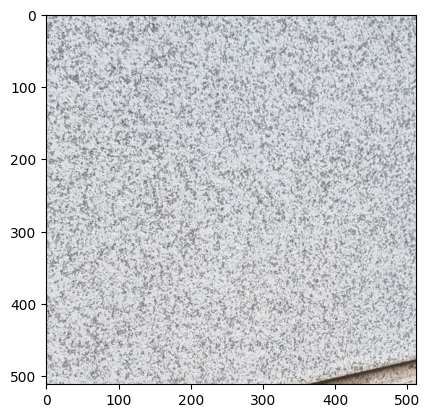

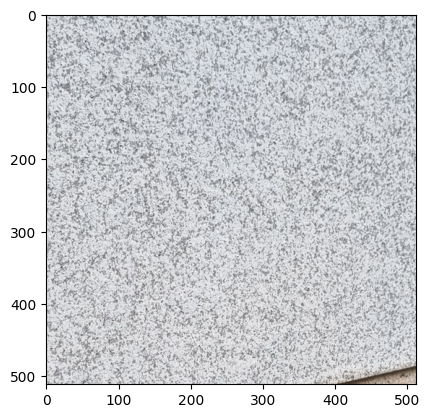

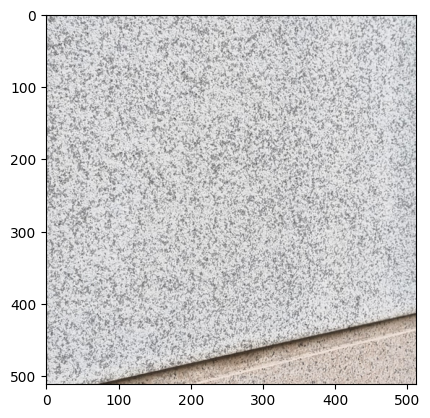

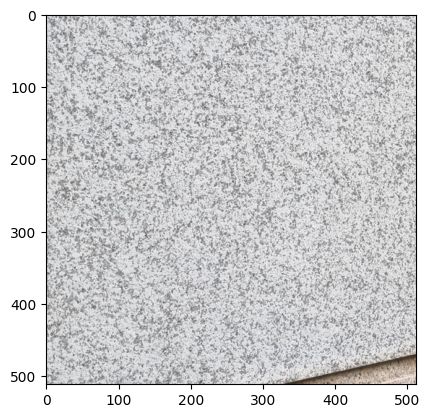

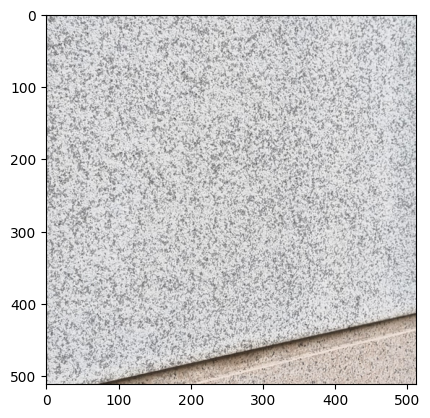

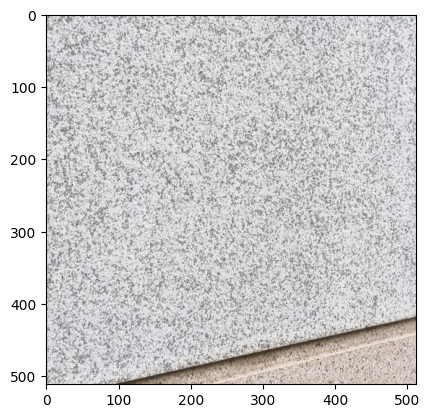

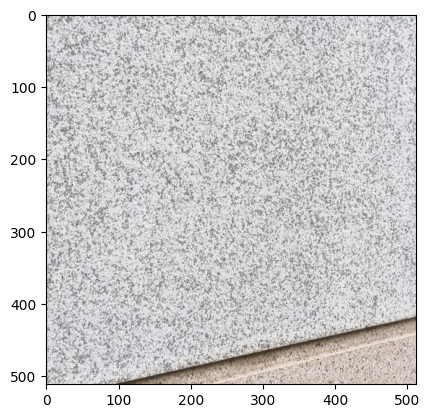

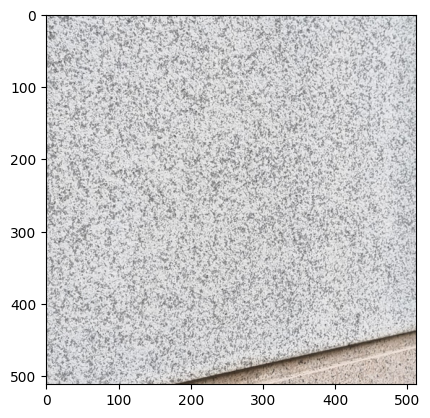

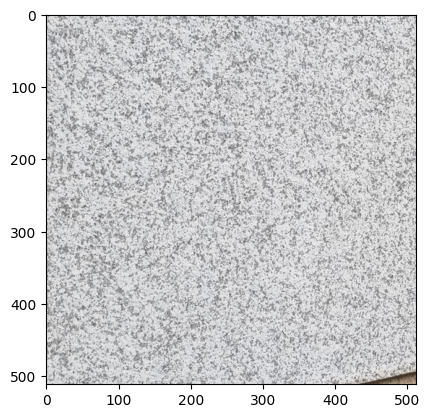

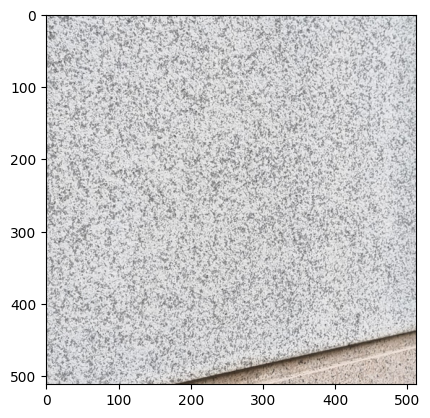

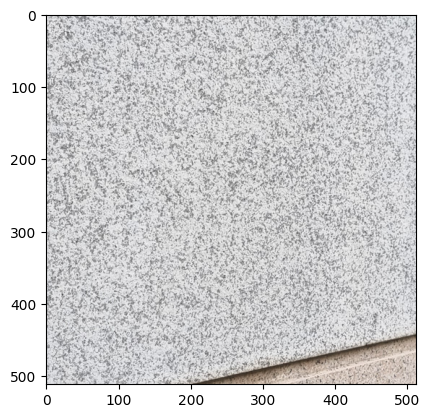

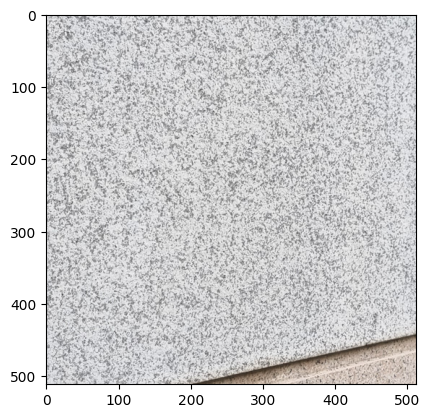

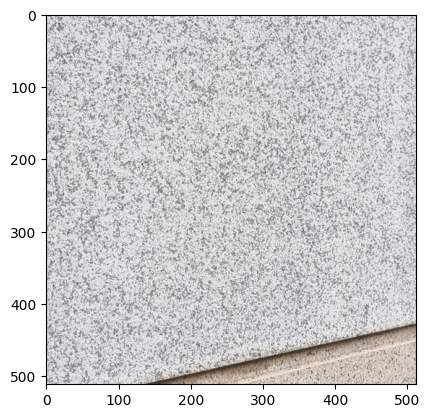

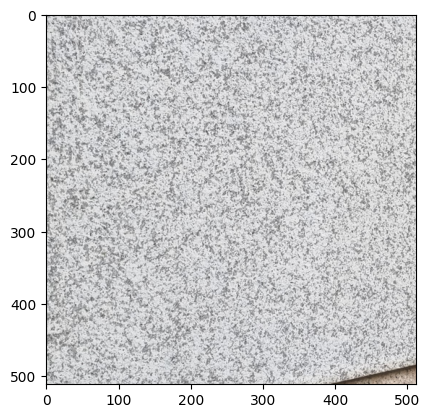

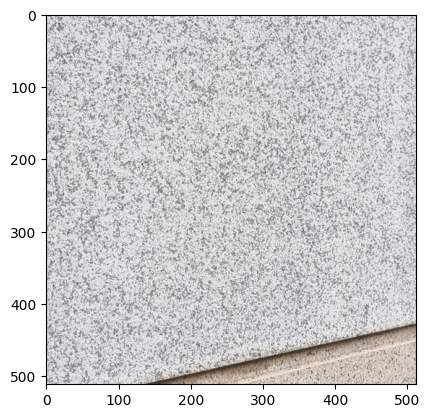

label is 1


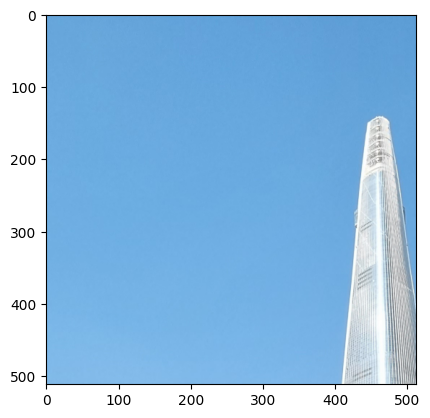

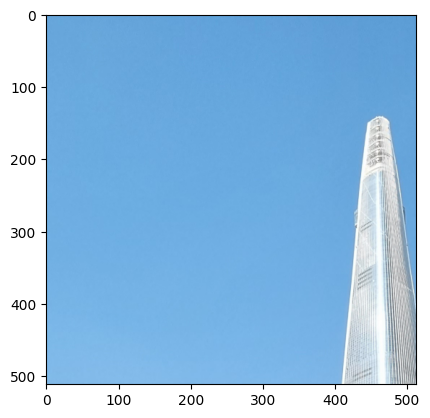

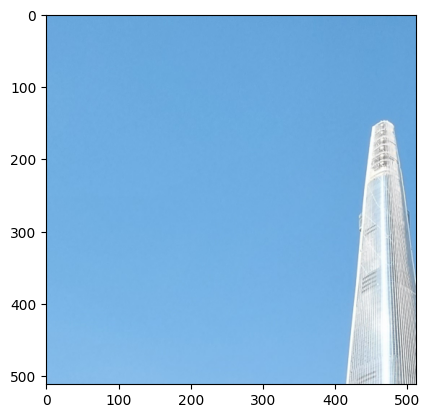

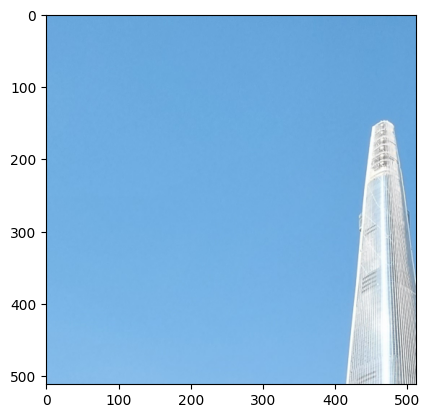

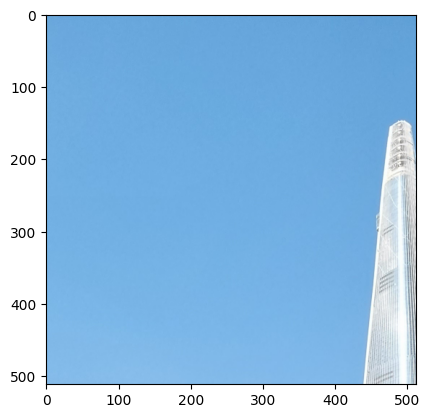

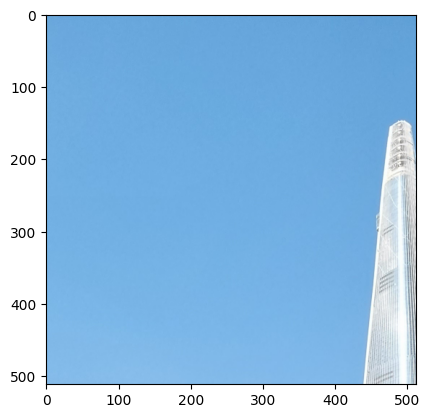

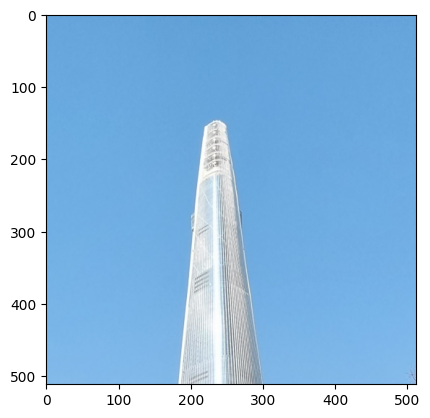

In [133]:
print('label is 0')
for image_path in np.array(image_paths)[labels==0]:
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()
print('label is 1')
for image_path in np.array(image_paths)[labels==1]:
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()

In [134]:
train_df = pd.DataFrame(columns=['image','label'])

In [135]:
train_df['image'] = [os.path.basename(image_path) for image_path in image_paths]
train_df['label'] = labels

In [136]:
train_df.to_csv('./train_preproc.csv', index=False)

In [137]:
test_image_paths = sorted(glob('stable-diffusion-2-inpainting//*.png'))
# test_image_paths = sorted(glob('./test_input_RealESRGAN//*.png'))

In [138]:
test_df = pd.DataFrame(columns=['image'])

In [139]:
test_df['image'] = [os.path.basename(image_path) for image_path in test_image_paths]

In [140]:
test_df.to_csv('./test_preproc.csv', index=False)

# 2. 모델 학습 코드

### 라이브러리 인스톨

In [141]:
#!pip install polygenerator lightning segmentation-models-pytorch

### 라이브러리 임포트 및 필요한 함수 작성

In [142]:
import os
import math
import random
import zipfile
import cv2
import numpy as np
import skimage
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
import segmentation_models_pytorch as smp

from tqdm.auto import tqdm
from glob import glob
from PIL import Image
from polygenerator import (
    random_polygon,
    random_star_shaped_polygon,
    random_convex_polygon,
)
from sklearn.model_selection import KFold
from skimage.metrics import structural_similarity as ski_ssim
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

from matplotlib import pyplot as plt

In [143]:
torch.set_float32_matmul_precision('medium')

In [144]:
def get_input_image(image, min_polygon_bbox_size=50):
    width, height = image.size
    while True:
        bbox_x1 = random.randint(0, width-min_polygon_bbox_size)
        bbox_y1 = random.randint(0, height-min_polygon_bbox_size)
        bbox_x2 = random.randint(bbox_x1, width)  # Ensure width > 10
        bbox_y2 = random.randint(bbox_y1, height)  # Ensure height > 10
        if (bbox_x2-bbox_x1)<min_polygon_bbox_size or (bbox_y2-bbox_y1)<min_polygon_bbox_size:
            continue
        
        mask_bbox = [bbox_x1, bbox_y1, bbox_x2, bbox_y2]
        mask_width = bbox_x2-bbox_x1
        mask_height = bbox_y2-bbox_y1
    
        num_points = random.randint(3,20)
        polygon_func = random.choice([
            random_polygon,
            random_star_shaped_polygon,
            random_convex_polygon
        ])
        polygon = polygon_func(num_points=num_points) #scaled 0~1
        polygon = [(round(r*mask_width), round(c*mask_height)) for r,c in polygon]
        polygon_mask = skimage.draw.polygon2mask((mask_width, mask_height), polygon)
        if np.sum(polygon_mask)>(min_polygon_bbox_size//2)**2:
            break
    full_image_mask = np.zeros((width, height), dtype=np.uint8)
    full_image_mask[bbox_x1:bbox_x2, bbox_y1:bbox_y2] = polygon_mask
    
    image_gray = image.convert('L')
    image_gray_array = np.array(image_gray)  # Convert to numpy array for manipulation
    random_color = random.randint(0, 255)  # Random grayscale color
    image_gray_array[full_image_mask == 1] = random_color
    image_gray_masked = Image.fromarray(image_gray_array)

    return {
        'image_gt':image,
        'mask':full_image_mask,
        'image_gray':image_gray,
        'image_gray_masked':image_gray_masked
    }

In [145]:
def get_ssim_score(true, pred):
    # 전체 RGB 이미지를 사용해 SSIM 계산 (channel_axis=-1)
    ssim_value = ski_ssim(true, pred, channel_axis=-1, data_range=pred.max() - pred.min())
    return ssim_value

def get_masked_ssim_score(true, pred, mask):
    # 손실 영역의 좌표에서만 RGB 채널별 픽셀 값 추출
    true_masked_pixels = true[mask > 0]
    pred_masked_pixels = pred[mask > 0]
    
    # 손실 영역 픽셀만으로 SSIM 계산 (채널축 사용)
    ssim_value = ski_ssim(
        true_masked_pixels, 
        pred_masked_pixels, 
        channel_axis=-1, 
        data_range=pred.max() - pred.min()
    )
    return ssim_value

def get_histogram_similarity(true, pred, cvt_color=cv2.COLOR_RGB2HSV):
    # BGR 이미지를 HSV로 변환
    true_hsv = cv2.cvtColor(true, cvt_color)
    pred_hsv = cv2.cvtColor(pred, cvt_color)

    # H 채널에서 히스토그램 계산 및 정규화
    hist_true = cv2.calcHist([true_hsv], [0], None, [180], [0, 180])
    hist_pred = cv2.calcHist([pred_hsv], [0], None, [180], [0, 180])
    hist_true = cv2.normalize(hist_true, hist_true).flatten()
    hist_pred = cv2.normalize(hist_pred, hist_pred).flatten()

    # 히스토그램 간 유사도 계산 (상관 계수 사용)
    similarity = cv2.compareHist(hist_true, hist_pred, cv2.HISTCMP_CORREL)
    return similarity

### 하이퍼 파라미터 설정, 데이터 로드 및 전처리

In [146]:
SEED=42
N_SPLIT=5
BATCH_SIZE=6
IMAGE_PREPROC_MEAN=0.5
IMAGE_PREPROC_STD=0.225
MIN_POLYGON_BBOX_SIZE = 50

In [147]:
TRAIN_DATA_DIR='./train_gt'
VALID_DATA_DIR=f'./valid_input/{SEED=}-{MIN_POLYGON_BBOX_SIZE=}'
TEST_DATA_DIR='./test_input'
SUBMISSON_DATA_DIR='./submission'
EXPERIMENT_NAME='smp-unet-resnet152-BATCH_SIZE=8-epoch=22_ESRGAN_INFER'

In [148]:
L.seed_everything(SEED)

Seed set to 42


42

In [149]:
train_df = pd.read_csv('./train_preproc.csv')
test_df = pd.read_csv('./test_preproc.csv')

In [150]:
os.makedirs(VALID_DATA_DIR, exist_ok=True)
for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img_path = train_df.iloc[idx, 0]
    img_path = os.path.join(TRAIN_DATA_DIR, img_path)
    save_image_name = os.path.basename(img_path).replace('TRAIN', 'VALID').replace('png','npy')
    save_image_path = f'{VALID_DATA_DIR}/{save_image_name}'
    if os.path.exists(save_image_path):
        continue
    image = Image.open(img_path)
    valid_input_image = get_input_image(image, MIN_POLYGON_BBOX_SIZE)
    np.save(save_image_path, valid_input_image)

  0%|          | 0/29603 [00:00<?, ?it/s]

In [151]:
train_df_outlier = train_df[train_df['label']==-1]
train_df = train_df[train_df['label']!=-1]

In [152]:
kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=SEED)

In [153]:
for fold_idx, (train_indices, valid_indices) in enumerate(kf.split(train_df['image'], train_df['label'])):
    train_fold_df = train_df.iloc[train_indices].reset_index(drop=True)
    valid_fold_df = train_df.iloc[valid_indices].reset_index(drop=True)
    valid_fold_df['image'] = valid_fold_df['image'].apply(lambda x: x.replace('TRAIN', 'VALID').replace('png', 'npy'))
    valid_fold_df = valid_fold_df.drop_duplicates('label') # for fast validation
    # train_fold_df = pd.concat([train_fold_df,train_df_outlier],axis=0).reset_index(drop=True)
    break

## 데이터셋 클래스 작성 및 초기화

In [154]:
class CustomImageDataset(Dataset):
    def __init__(self, df, data_dir='./data/train_gt', mode='train', min_polygon_bbox_size=MIN_POLYGON_BBOX_SIZE):
        self.df = df
        self.data_dir = data_dir
        self.mode = mode
        self.min_polygon_bbox_size = min_polygon_bbox_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and label
        img_path = self.df.iloc[idx, 0]  # Assuming first column is the path
        img_path = os.path.join(self.data_dir, img_path)
        
        # Apply augmentation if in training mode
        if self.mode == 'train':
            image = Image.open(img_path)
            image_input = get_input_image(image, self.min_polygon_bbox_size)
            return image_input

        elif self.mode == 'valid':
            image_input = self.load_input_image(img_path)
            return image_input
        elif self.mode == 'test':
            image = Image.open(img_path)
            return {
                'image_gray_masked':image
            }

    def load_input_image(self, img_input_path):
        image_input = np.load(img_input_path, allow_pickle=True)
        return image_input.item()
    

In [155]:
train_dataset = CustomImageDataset(train_fold_df, data_dir=TRAIN_DATA_DIR, mode='train')
valid_dataset = CustomImageDataset(valid_fold_df, data_dir=VALID_DATA_DIR, mode='valid')
test_dataset = CustomImageDataset(test_df, data_dir=TEST_DATA_DIR, mode='test')

### 데이터 시각화

In [156]:
for idx, data in tqdm(enumerate(valid_dataset)):
    break

0it [00:00, ?it/s]

In [157]:
# plt.imshow(data['mask'])

In [158]:
# data['image_gray_masked']

In [159]:
# data['image_gray']

In [160]:
# data['image_gt']

## 데이터로더 작성 및 초기화

In [161]:
class CollateFn:
    def __init__(self, mean=IMAGE_PREPROC_MEAN, std=IMAGE_PREPROC_STD, mode='train'):
        self.mode = mode
        self.mean = mean
        self.std = std

    def __call__(self, examples):
        if self.mode =='train' or self.mode=='valid':
            # Initialize lists to store each component of the batch
            masks= []
            images_gray = []
            images_gray_masked = []
            images_gt = []
    
            for example in examples:
                # Assuming each example is a dictionary with keys 'mask', 'image_gray', 'image_gray_masked', 'image_gt'
                masks.append(example['mask'])
                images_gray.append(self.normalize_image(example['image_gray']))
                images_gray_masked.append(self.normalize_image(example['image_gray_masked']))
                images_gt.append(self.normalize_image(np.array(example['image_gt'])))

            return {
                'masks': torch.from_numpy(np.stack(masks)).long(),
                'images_gray': torch.from_numpy(np.stack(images_gray)).unsqueeze(1).float(),
                'images_gray_masked': torch.from_numpy(np.stack(images_gray_masked)).unsqueeze(1).float(),
                'images_gt': torch.from_numpy(np.stack(images_gt)).permute(0,3,1,2).float()
            }

        elif self.mode == 'test':
            images_gray_masked = []
            for example in examples:
                images_gray_masked.append(self.normalize_image(example['image_gray_masked']))
            return {
                'images_gray_masked': torch.from_numpy(np.stack(images_gray_masked)).unsqueeze(1).float(),
            }

    def normalize_image(self, image):
        return (np.array(image)/255-self.mean)/self.std

In [162]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=CollateFn(mode='train'), num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE*2, shuffle=False, collate_fn=CollateFn(mode='valid'), num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, collate_fn=CollateFn(mode='test'))

## 모델 작성 및 초기화

In [ ]:
class LitIRModel(L.LightningModule):
    def __init__(self, model_1, model_2, image_mean=IMAGE_PREPROC_MEAN, image_std=IMAGE_PREPROC_STD):
        super().__init__()
        self.model_1 = model_1
        self.model_2 = model_2
        self.image_mean=image_mean
        self.image_std=image_std

    def forward(self, images_gray_masked):
        images_gray_restored = self.model_1(images_gray_masked)+images_gray_masked
        images_restored = self.model_2(images_gray_restored)
        return images_gray_restored, images_restored
        
    def unnormalize(self, output, round=False):
        image_restored = ((output*self.image_std+self.image_mean)*255).clamp(0,255)
        if round:
            image_restored = torch.round(image_restored)
        return image_restored
    
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=1e-5)
        return opt

    def training_step(self, batch, batch_idx):
        masks, images_gray_masked, images_gray, images_gt = batch['masks'], batch['images_gray_masked'], batch['images_gray'], batch['images_gt']
        images_gray_restored, images_restored = self(images_gray_masked)
        
        loss_pixel_gray = F.l1_loss(images_gray, images_gray_restored, reduction='mean') * 0.5 + F.mse_loss(images_gray, images_gray_restored, reduction='mean') * 0.5
        loss_pixel = F.l1_loss(images_gt, images_restored, reduction='mean') * 0.5 + F.mse_loss(images_gt, images_restored, reduction='mean') * 0.5
        loss = loss_pixel_gray * 0.5 + loss_pixel * 0.5

        self.log("train_loss", loss, on_step=True, on_epoch=False)
        self.log("train_loss_pixel_gray", loss_pixel_gray, on_step=True, on_epoch=False)
        self.log("train_loss_pixel", loss_pixel, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        masks, images_gray_masked, images_gt = batch['masks'], batch['images_gray_masked'], batch['images_gt']
        images_gray_restored, images_restored = self(images_gray_masked)
        images_gt, images_restored = self.unnormalize(images_gt, round=True), self.unnormalize(images_restored, round=True)
        masks_np = masks.detach().cpu().numpy()
        images_gt_np = images_gt.detach().cpu().permute(0,2,3,1).float().numpy().astype(np.uint8)
        images_restored_np = images_restored.detach().cpu().permute(0,2,3,1).float().numpy().astype(np.uint8)
        total_ssim_score = 0
        masked_ssim_score = 0
        hist_sim_score = 0
        for image_gt_np, image_restored_np, mask_np in zip(images_gt_np, images_restored_np, masks_np):
            total_ssim_score += get_ssim_score(image_gt_np, image_restored_np) / len(images_gt)
            masked_ssim_score += get_masked_ssim_score(image_gt_np, image_restored_np, mask_np)/ len(images_gt)
            hist_sim_score += get_histogram_similarity(image_gt_np, image_restored_np, cv2.COLOR_RGB2HSV)/ len(images_gt)
        score = total_ssim_score * 0.2 + masked_ssim_score * 0.4 + hist_sim_score * 0.4
        self.log(f"val_score", score, on_step=False, on_epoch=True)
        self.log(f"val_total_ssim_score", total_ssim_score, on_step=False, on_epoch=True)
        self.log(f"val_masked_ssim_score", masked_ssim_score, on_step=False, on_epoch=True)
        self.log(f"val_hist_sim_score", hist_sim_score, on_step=False, on_epoch=True)
        return score

    def predict_step(self, batch, batch_idx):
        images_gray_masked = batch['images_gray_masked']
        images_gray_restored, images_restored = self(images_gray_masked)
        images_restored = self.unnormalize(images_restored, round=True)
        images_restored_np = images_restored.detach().cpu().permute(0,2,3,1).float().numpy().astype(np.uint8)
        return images_restored_np


In [171]:
# 다른모델 사용
# https://smp.readthedocs.io/en/latest/encoders.html

# gray mask restoration
model_1 = smp.Unet(
    encoder_name="resnet152",        
    encoder_weights="imagenet",     
    in_channels=1,                  
    classes=1,                      
)

# gray -> color
model_2 = smp.Unet(
    encoder_name="resnet152",        
    encoder_weights="imagenet",     
    in_channels=1,                  
    classes=3,                      
)

lit_ir_model = LitIRModel(model_1=model_1, model_2=model_2)


## 모델 학습

In [165]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_score',
    mode='max',
    dirpath='./checkpoint/',
    filename=f'smp-unet-timm-res2net50_26w_8s-{BATCH_SIZE=}'+'-{epoch:02d}-{val_score:.4f}',
    save_top_k=3,
    save_weights_only=True,
    verbose=True
)
earlystopping_callback = EarlyStopping(monitor="val_score", mode="max", patience=3)

In [166]:
trainer = L.Trainer(max_epochs=100, precision='bf16-mixed', callbacks=[checkpoint_callback, earlystopping_callback], detect_anomaly=False)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [169]:
trainer.fit(lit_ir_model, train_dataloader, valid_dataloader)

/home/gooruem/anaconda3/envs/IMGRT/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/gooruem/Competition/IMGRT/checkpoint exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | model_1 | UnetPlusPlus | 83.6 M | train
1 | model_2 | UnetPlusPlus | 83.6 M | train
-------------------------------------------------
167 M     Trainable params
0         Non-trainable params
167 M     Total params
668.923   Total estimated model params size (MB)
1146      Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

## 모델 불러오기 및 예측

In [172]:
lit_ir_model = LitIRModel.load_from_checkpoint(
    '/home/gooruem/Competition/IMGRT/checkpoint/smp-unet-resnet152-BATCH_SIZE=8-epoch=22-val_score=0.6190.ckpt',
    model_1=model_1,
    model_2=model_2,
)

In [173]:
predictions = trainer.predict(lit_ir_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/gooruem/anaconda3/envs/IMGRT/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/home/gooruem/Competition/IMGRT/test_input/train0.png'

In [107]:
predictions = np.concatenate(predictions)

In [108]:
submission_dir = os.path.join(SUBMISSON_DATA_DIR, EXPERIMENT_NAME)
submission_file = f'{SUBMISSON_DATA_DIR}/{EXPERIMENT_NAME}.zip'
os.makedirs(submission_dir, exist_ok=True)

In [109]:
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    image_pred = Image.fromarray(predictions[idx])
    image_pred.save(os.path.join(submission_dir, row['image']), "PNG")

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Step 3: Compress the directory into a ZIP file using glob
with zipfile.ZipFile(submission_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file_path in glob(f"{submission_dir}/*.png"):
        arcname = os.path.relpath(file_path, submission_dir)
        zipf.write(file_path, arcname)

## OUPUT -> DRCT -> 1/4

In [ ]:
# %run 매직 명령어 사용
!python ./DRCT/inference.py \
    --input /home/gooruem/Competition/IMGRT/submission/smp-unet-resnet152-BATCH_SIZE=8-epoch=22 \
    --output /home/gooruem/Competition/IMGRT/submission/resnet152-BATCH_SIZE=8-epoch=22_DRCT_L \
    --model_path /home/gooruem/Competition/IMGRT/DRCT-L_X4.pth


/home/gooruem/.local/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/gooruem/Competition/IMGRT/./DRCT/inference.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user v

In [ ]:
import os
import zipfile
from PIL import Image

def process_images(input_folder, output_zip_path):
    # 임시 폴더 생성
    temp_folder = os.path.join(input_folder, "processed_images")
    os.makedirs(temp_folder, exist_ok=True)
    
    # 이미지 처리
    for file_name in os.listdir(input_folder):
        input_file_path = os.path.join(input_folder, file_name)
        
        # 이미지 파일만 처리
        if not os.path.isfile(input_file_path) or not file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            continue
        
        # 이름 변경
        new_name = file_name.replace("_DRCT-L_X4", "")  # "_DRCT-L_X4" 제거
        output_file_path = os.path.join(temp_folder, new_name)
        
        # 이미지 크기 변경
        with Image.open(input_file_path) as img:
            new_size = (img.width // 4, img.height // 4)  # 크기를 4배 축소
            img_resized = img.resize(new_size, Image.LANCZOS)  # LANCZOS 사용
            img_resized.save(output_file_path)
    
    # 압축 파일 생성
    with zipfile.ZipFile(output_zip_path, 'w') as zipf:
        for file_name in os.listdir(temp_folder):
            file_path = os.path.join(temp_folder, file_name)
            zipf.write(file_path, arcname=file_name)  # 압축 파일에 저장
    
    # 임시 폴더 삭제
    for file_name in os.listdir(temp_folder):
        os.remove(os.path.join(temp_folder, file_name))
    os.rmdir(temp_folder)
    print(f"Processed images saved in: {output_zip_path}")

# 입력 및 출력 경로 설정
input_folder = "/home/gooruem/Competition/IMGRT/submission/resnet152-BATCH_SIZE=8-epoch=22_DRCT_L"  # 변경 전 폴더 경로
output_zip_path = "/home/gooruem/Competition/IMGRT/submission/resnet152-BATCH_SIZE=8-epoch=22_DRCT_L.zip"  # 압축 파일 저장 경로

# 함수 실행
process_images(input_folder, output_zip_path)
